# Benchmarking: ECG Similarity Search Engine

This secondary Jupyter notebook contains experimental code, parameter configurations, and plotting functions used to generate the scalability analysis. It is intended primarily for internal evaluation and may appear somewhat exploratory or loosely structured. Its focus is on analyzing query performance across different settings (e.g., number of ECGs, selected feature groups, and top-k values).

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath(".."))

from src.data_generator import DataGenerator
from src.data_preprocessor import DataPreprocessor
from src.similarity_searcher import SimilaritySearcher

Some helper functions to run the benchmarks:

In [2]:
def get_query_indices_per_cluster(
    data: pd.DataFrame, random_state: int = 42
) -> list[int]:
    """
    Select one representative ECG index per cluster.

    Parameters
    ----------
    data : pd.DataFrame
        The dataset containing a "cluster" column.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    list[int]
        A list of row indices, one per unique cluster.
    """
    rng = np.random.default_rng(random_state)
    cluster_indices = []

    for cluster in data["cluster"].unique():
        cluster_df = data[data["cluster"] == cluster]
        sampled_idx = rng.choice(cluster_df.index, size=1)[0]
        cluster_indices.append(sampled_idx)

    return cluster_indices


def run_benchmark(
    searcher, preprocessor, data, query_indices, query_ids, configs, top_k
):
    results = []

    for i, idx in enumerate(query_indices):
        query_df = data.iloc[[idx]]
        query_cluster = query_df["cluster"].values[0]
        query_vec = preprocessor.transform(query_df)

        for cfg in configs:
            start = time.time()
            indices, _ = searcher.search(
                query_vec,
                top_k=top_k,
                selected_groups=cfg["groups"],
                weights=cfg.get("weights"),
            )
            elapsed = time.time() - start
            result = {
                "query_index": idx,
                "query_id": query_ids[i],
                "query_cluster": query_cluster,
                "selected_groups": "+".join(cfg["groups"]),
                "weights": cfg.get("weights"),
                "elapsed": elapsed,
                "n_results": len(indices),
                "same_cluster_frac": (
                    (data.iloc[indices]["cluster"] == query_cluster).mean()
                ),
            }
            results.append(result)

    return pd.DataFrame(results)

Run the following cells once for every desired N that needs to be included in the benchmark

In [3]:
N = 10000
generator = DataGenerator(num_ecgs=N)
data = generator.generate_data()

preprocessor = DataPreprocessor()
processed_data = preprocessor.fit_transform(data)


index_types = {
    "heart_rate": "hnsw",
    "risk_scores": "hnsw",
    "embedding": "hnsw",
    "beat_props": "hnsw",
}

searcher = SimilaritySearcher(
    processed_data, preprocessor.group_shapes, group_index_types=index_types
)

SingleIndex: building index with type <hnsw>: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]
HybridIndexer: building for group <heart_rate> with index type <hnsw>: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]
HybridIndexer: building for group <risk_scores> with index type <hnsw>: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]
HybridIndexer: building for group <embedding> with index type <hnsw>: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]
HybridIndexer: building for group <beat_props> with index type <hnsw>: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


In [ ]:
# Map ecg_id to position
id_to_index = {ecg_id: i for i, ecg_id in enumerate(data.index)}

indices_per_cluster = get_query_indices_per_cluster(data)  # string IDs
int_indices_per_cluster = [id_to_index[ecg_id] for ecg_id in indices_per_cluster]

# Define the selected groups to test
group_combinations = [
    ["heart_rate"],
    ["risk_scores"],
    ["embedding", "heart_rate"],
    ["beat_props", "risk_scores"],
    ["embedding", "heart_rate", "risk_scores"],
    ["embedding", "beat_props", "risk_scores"],
    ["embedding", "heart_rate", "risk_scores", "beat_props"],
]

# Define the different top_k values to test
top_k_values = [100, 500, 1000]

# Run all combinations
all_results = []

for top_k in top_k_values:
    configs = [{"groups": g} for g in group_combinations]
    benchmark_df = run_benchmark(
        searcher=searcher,
        preprocessor=preprocessor,
        data=data,
        query_indices=int_indices_per_cluster,
        query_ids=indices_per_cluster,
        configs=configs,
        top_k=top_k,
    )
    benchmark_df["top_k"] = top_k
    all_results.append(benchmark_df)

final_results = pd.concat(all_results, ignore_index=True)

final_results.to_csv(f"benchmark_results_{N}.csv")

Once the results are saved for each dataset size, we can derive insights on parameters.

In [5]:
total_df = pd.DataFrame()

for N in [10000, 100000, 1000000, 10000000]:
    benchmark_df = pd.read_csv(f"benchmark_results_{N}.csv")
    benchmark_df["N"] = N
    total_df = pd.concat([total_df, benchmark_df], ignore_index=True)

total_df["n_groups"] = total_df["selected_groups"].str.split("+").apply(len)

Some helper functions to retrieve the plots

In [8]:
def plot_query_time_by_N_topk_ngroups(df):
    """
    Create a merged plot showing:
    - X-axis: dataset size (N)
    - Y-axis: average query time (elapsed)
    - Hue (color): top_k
    - Style (marker shape): n_groups
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x="N",
        y="elapsed",
        hue="top_k",
        style="n_groups",
        markers=True,
        dashes=True,
        ci=None,
        palette=sns.color_palette("colorblind"),
    )
    plt.xscale("log")
    plt.xlabel("Dataset size (N)")
    plt.ylabel("Query time (s)")
    plt.title("Query time vs dataset size (log-scale), grouped by top_k and n_groups")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_avg_query_time_vs_N(df):
    grouped = (
        df.groupby("N")
        .agg(avg_time=("elapsed", "mean"), std_time=("elapsed", "std"))
        .reset_index()
    )

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=grouped, x="N", y="avg_time", marker="o")
    plt.xscale("log")
    plt.title(
        "Average query time vs dataset size (N) [averaged over top_k and n_groups]"
    )
    plt.xlabel("Dataset size (N)")
    plt.ylabel("Average query time (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_avg_query_time_vs_n_groups(df):
    grouped = (
        df.groupby("n_groups")
        .agg(avg_time=("elapsed", "mean"), std_time=("elapsed", "std"))
        .reset_index()
    )

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=grouped, x="n_groups", y="avg_time", marker="o")
    plt.title(
        "Average query time vs number of feature groups [averaged over N and top_k]"
    )
    plt.xlabel("Number of selected groups")
    plt.ylabel("Average query time (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_avg_query_time_vs_top_k(df):
    grouped = (
        df.groupby("top_k")
        .agg(avg_time=("elapsed", "mean"), std_time=("elapsed", "std"))
        .reset_index()
    )

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=grouped, x="top_k", y="avg_time", marker="o")
    plt.title("Average query time vs top-k [averaged over N and n_groups]")
    plt.xlabel("Top-k")
    plt.ylabel("Average query time (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/r7/3y9_c4qd2q7f32mwvk1cvdhm0000gn/T/ipykernel_66760/2610994360.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/r7/3y9_c4qd2q7f32mwvk1cvdhm0000gn/T/ipykernel_66760/2610994360.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(


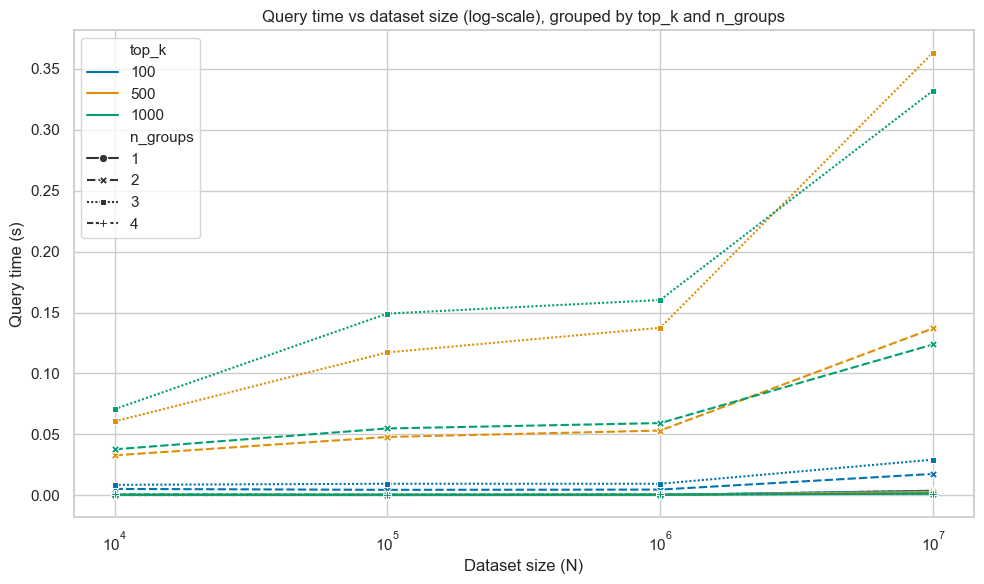

In [10]:
plot_query_time_by_N_topk_ngroups(total_df)

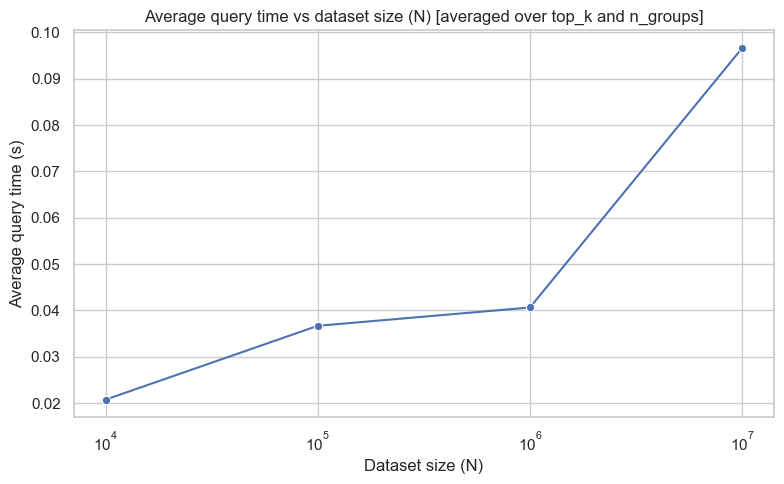

In [11]:
plot_avg_query_time_vs_N(total_df)

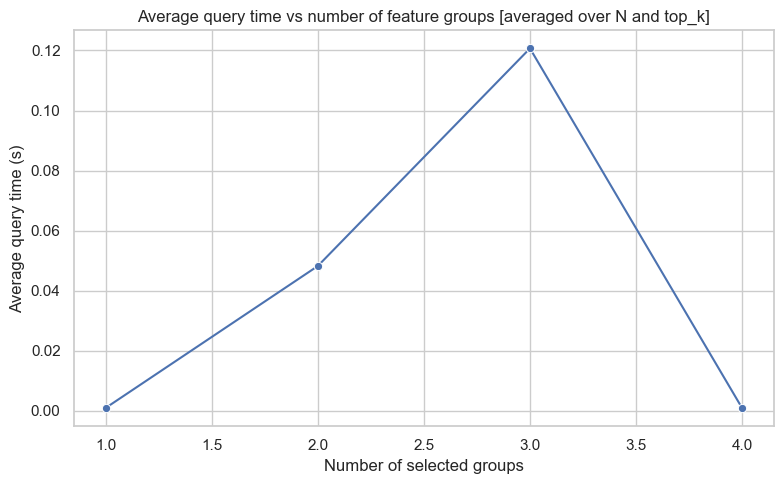

In [12]:
plot_avg_query_time_vs_n_groups(total_df)

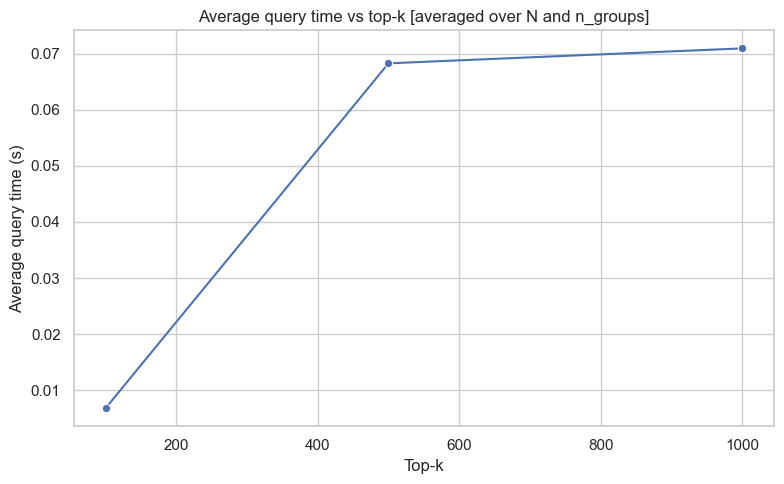

In [13]:
plot_avg_query_time_vs_top_k(total_df)

In [14]:
def plot_pca_clusters(
    df, cluster_col="cluster", n_components=2, title="PCA of Preprocessed ECG Data"
):
    """
    Plots a 2D PCA projection of the ECG feature data colored by cluster.

    Parameters:
    - df: DataFrame containing the preprocessed features and a 'cluster' column
    - cluster_col: name of the column with cluster labels
    - n_components: number of PCA dimensions to reduce to (default is 2)
    - title: title of the plot
    """
    # Exclude non-feature columns
    feature_cols = [
        col
        for col in df.columns
        if col != cluster_col and df[col].dtype in [float, int]
    ]
    X = df[feature_cols].values
    y = df[cluster_col].values

    # PCA projection
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Plot
    pca_df = pd.DataFrame({"PC1": X_pca[:, 0], "PC2": X_pca[:, 1], cluster_col: y})

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=pca_df, x="PC1", y="PC2", hue=cluster_col, palette="tab10", s=50, alpha=0.7
    )
    plt.title(title)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
    plt.legend(title=cluster_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In addition, it may be useful to plot a PCA on the pre-processed data to valide pre-processing and separability in the synthetic data

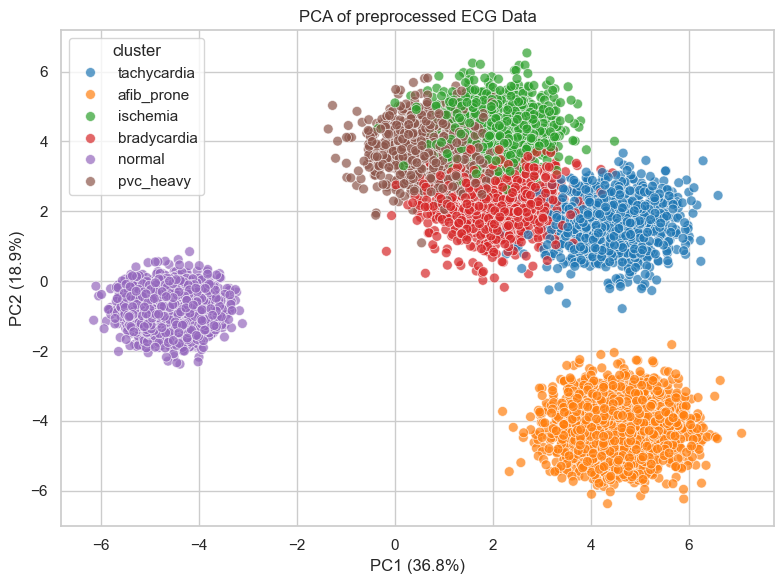

In [15]:
# turn into dataframe for plotting

processed_data = pd.DataFrame(processed_data, index=data.index)
processed_data["cluster"] = data["cluster"]

plot_pca_clusters(
    processed_data,
    cluster_col="cluster",
    n_components=2,
    title="PCA of preprocessed ECG Data",
)